# Plant Infection Multi-Class Classification through Convolutional Neural Network Fine-Tuning

Notebook by Aditya Tapshalkar

Kaggle dataset: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

---

## Abstract
This notebook will detail a process of fine-tuning a convolutional neural network (CNN) model to classify plant disease from plant leaf images. The dataset provided is an augmented version of the original [PlantVillage dataset](https://github.com/spMohanty/PlantVillage-Dataset). The goal of this classifier is to classify images of leaves (without any preprocessing) as one of the many classes on which this model is trained.

## Introduction
Disease and pests are common causes of significant agricultural shortages globally. Agricultural shortages in major crops affect population food supply, which can lead to famine and undernourishment. One study from 2019 reports crop yield losses among wheat, rice, maize, potato, and soybean to average around 20-40% globally primarily due to pathogen and pests, with higher loss estimates in regions with high food deficiency and fast-growing populations (Savary et al.). This study also found smallholder farmers in Central and South America suffering more significantly in agricultural yields, reporting nearly 50% of crop yield loss in beans, maize, and potato crops due to plant diseases. Pests and disease in staple crops directly impact food supply and threaten food security in many regions globally.

Plant disease is characterized by deterioration in plant yield, quality, or growth due to bacterial, viral, and fungal infections. Plant diseases include blight, rot, spotting, scabbing, canker, mold, rust, mildew, and wilt, among other diseases. These diseases can affect plants in different ways: wilting occurs during loss of turgor pressure in cells and tissue due to biotic and abiotic factors; spotting occurs due to partial death (necrosis) of plant tissue due to biotic factors; mold and rot are fungal infections that destroy plant cellular tissue and organelles; and discoloration due to viral infection can cause chloroplast dysfunction (Nazarov et al.). Pests are defined as insects, arthropods, and other small animals such as rodents that feed on plants. "Chewing" pests feed on plant leaves, stems, roots, and flowers of plant. "Sucking" pests feed on sap and plant cell contents and can cause various diseases through pathogen transfer during the feeding process. Some insects damage plants by cutting leafs for laying eggs (“Insects and Their Injury to Plants”).

Knowing the appropriate treatment to apply to infected plants is paramount to sustaining plant health. Disease- and pest-specific treatments exist for improving plant conditions. For example, fungal infections can be treated through fungicides; some infections can be treated through pruning affected plant tissue; and pests can be deterred by wiping plants with rubbing alcohol, soapy water, or insecticide (“14 Common Plant Diseases: How to Identify & Treat Them”).

ML and deep learning have been employed in the past in detecting and classifying plant infection. One research survey by Shoaib et al. detail common approaches to plant disease detection using state-of-the-art machine learning and deep learning models. In this survey, Shoaib et al. describe applications of deep learning and convolutional neural network models such as YOLO ("You Only Look Once") for identification of plant lesions and pests, and ResNet and GoogLeNet for plant lesion segmentation, among other solutions.

### Objective
In this notebook, I will be fine-tuning a deep convolutional network (ResNet) on an augmented PlantVillage dataset for multi-class classification across various plant diseases.

### Dataset
The dataset used in this case study is an augmented version of the PlantVillage dataset (Mohanty et al.) (Bhattarai). This augmented dataset includes approximately 87,000 RGB images of healthy and diseased crop leaves, categorized across 38 different labels.




In [20]:
%env KAGGLEHUB_CACHE=/mnt/devbox/kaggle
%matplotlib inline

import os
from PIL import Image

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

torch.manual_seed(42)
print("Torch version:", torch.__version__)
print("Current device:", "cuda" if torch.cuda.is_available() else "cpu")

env: KAGGLEHUB_CACHE=/mnt/devbox/kaggle
Torch version: 2.5.1
Current device: cuda


In [21]:
# Downloading dataset
path = os.path.join(os.getenv('KAGGLEHUB_CACHE'), "datasets", "vipoooool/new-plant-diseases-dataset", "versions", "2")
# path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to dataset files:", path)

Path to dataset files: /mnt/devbox/kaggle/datasets/vipoooool/new-plant-diseases-dataset/versions/2


In [22]:
classes = os.listdir(os.path.join(path, "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train"))
sorted(classes)

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [32]:
train_class_list = []
for train_class in classes:
    for file in os.scandir(os.path.join(path,  "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "train", str(train_class))):
        train_class_list.append({
            'class': train_class,
            'filepath': file.path
        })

df_train = pd.DataFrame(train_class_list)
df_train.head()

class                                           filepath
0  Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
1  Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
2  Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
3  Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
4  Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...

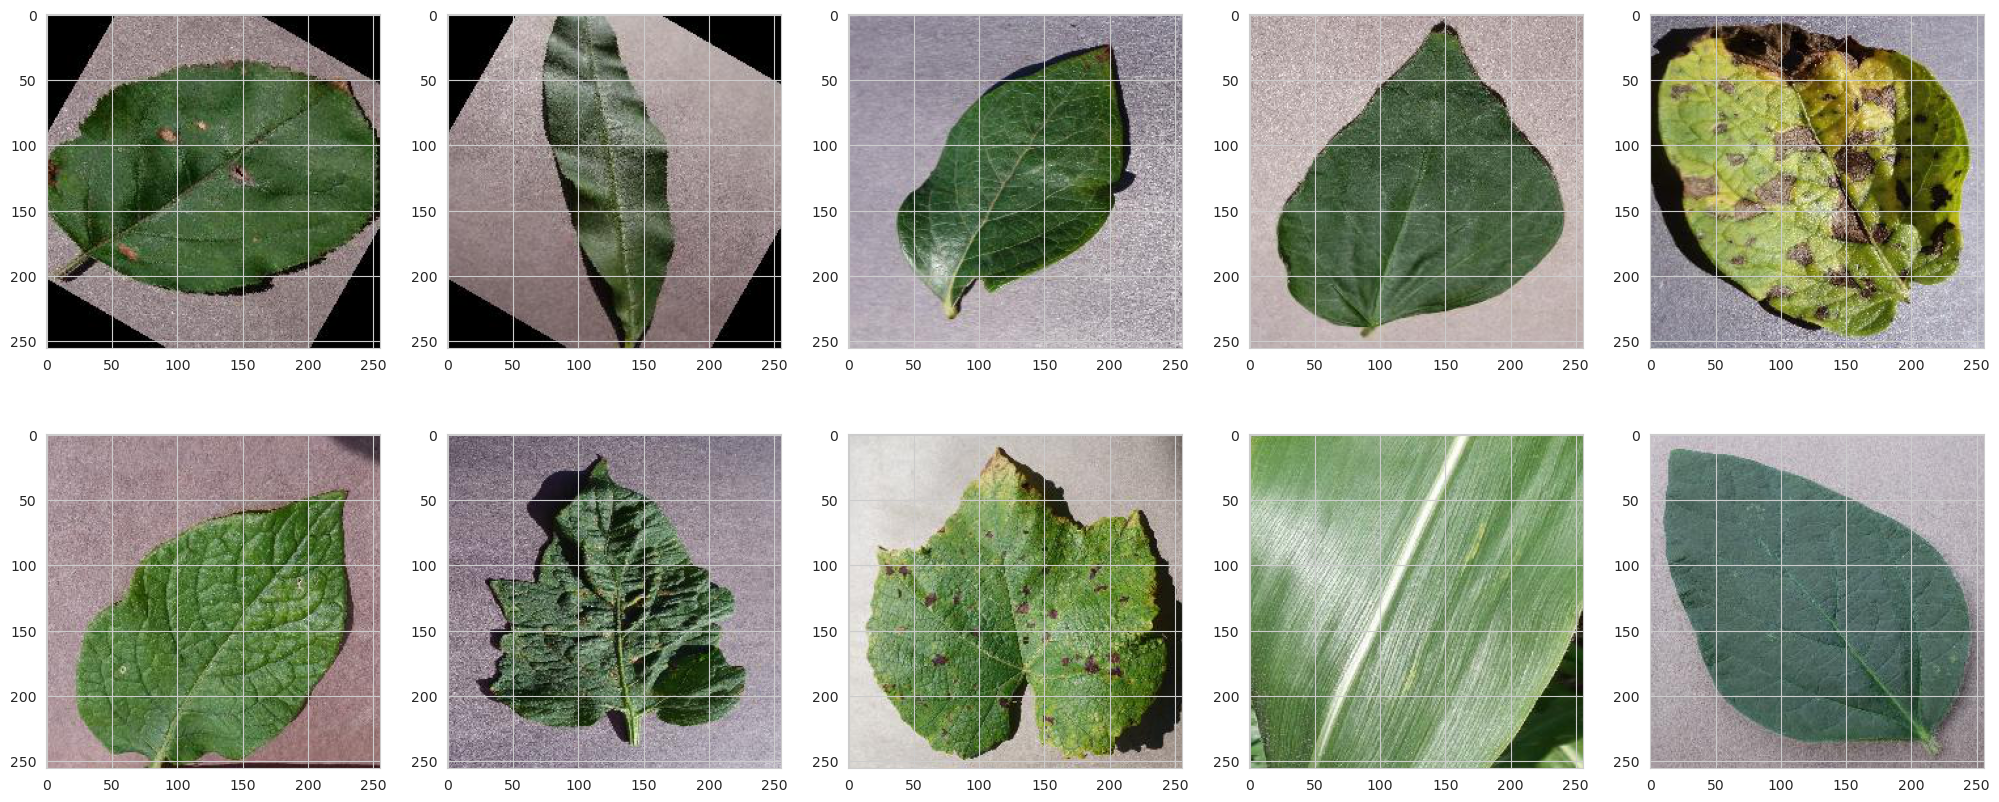

In [35]:
# Checking sample of train images
train_img_filepaths = df_train.sample(10)['filepath']
train_imgs = list([np.asarray(Image.open(fp)) for fp in train_img_filepaths])

fig, ax = plt.subplots(ncols=(len(train_imgs) // 2), nrows=2, figsize=(25, 10))
[ax[n // (len(train_imgs) // 2)][n % (len(train_imgs) // 2)].imshow(train_imgs[n]) for n in range(len(train_imgs))]

In [26]:
val_class_list = []
for val_class in classes:
    for file in os.scandir(os.path.join(path,  "New Plant Diseases Dataset(Augmented)", "New Plant Diseases Dataset(Augmented)", "valid", str(val_class))):
        val_class_list.append({
            'class': val_class,
            'filepath': file.path
        })

df_val = pd.DataFrame(val_class_list)
df_val

class                                           filepath
0         Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
1         Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
2         Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
3         Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
4         Soybean___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
...                     ...                                                ...
17567  Strawberry___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
17568  Strawberry___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
17569  Strawberry___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
17570  Strawberry___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
17571  Strawberry___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...

[17572 rows x 2 columns]

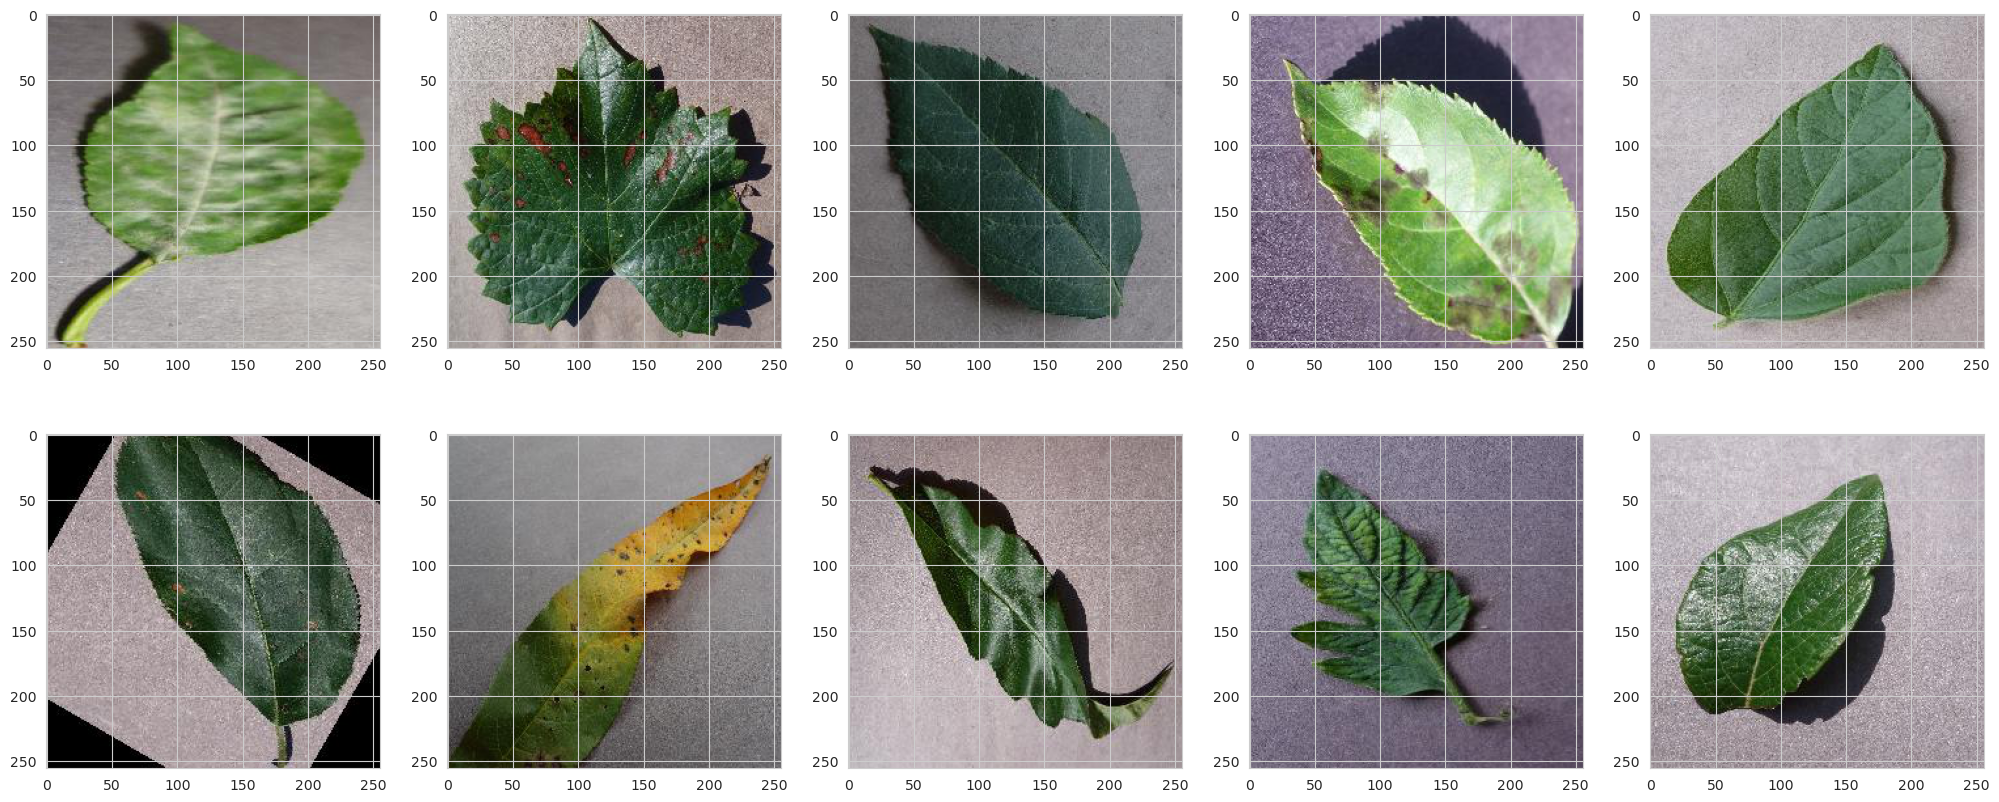

In [36]:
# Checking sample of validation images
val_img_filepaths = df_val.sample(10)['filepath']
val_imgs = list([np.asarray(Image.open(fp)) for fp in val_img_filepaths])

fig, ax = plt.subplots(ncols=(len(val_imgs) // 2), nrows=2, figsize=(25, 10))
[ax[n // (len(val_imgs) // 2)][n % (len(val_imgs) // 2)].imshow(val_imgs[n]) for n in range(len(val_imgs))]

> Note: At this point, output datapoints needed to be formatted in a similar directory hierarchy similar to training and validation datasets.

In [31]:
test_class_list = []
for test_class in classes:
    for file in os.scandir(os.path.join(path, "test", "test",str(test_class))):
        test_class_list.append({
            'class': test_class,
            'filepath': file.path
        })

df_test = pd.DataFrame(test_class_list)
df_test.head()

class                                           filepath
0  Apple___Apple_scab  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
1  Apple___Apple_scab  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
2  Apple___Apple_scab  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
3    Potato___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...
4    Potato___healthy  /mnt/devbox/kaggle/datasets/vipoooool/new-plan...

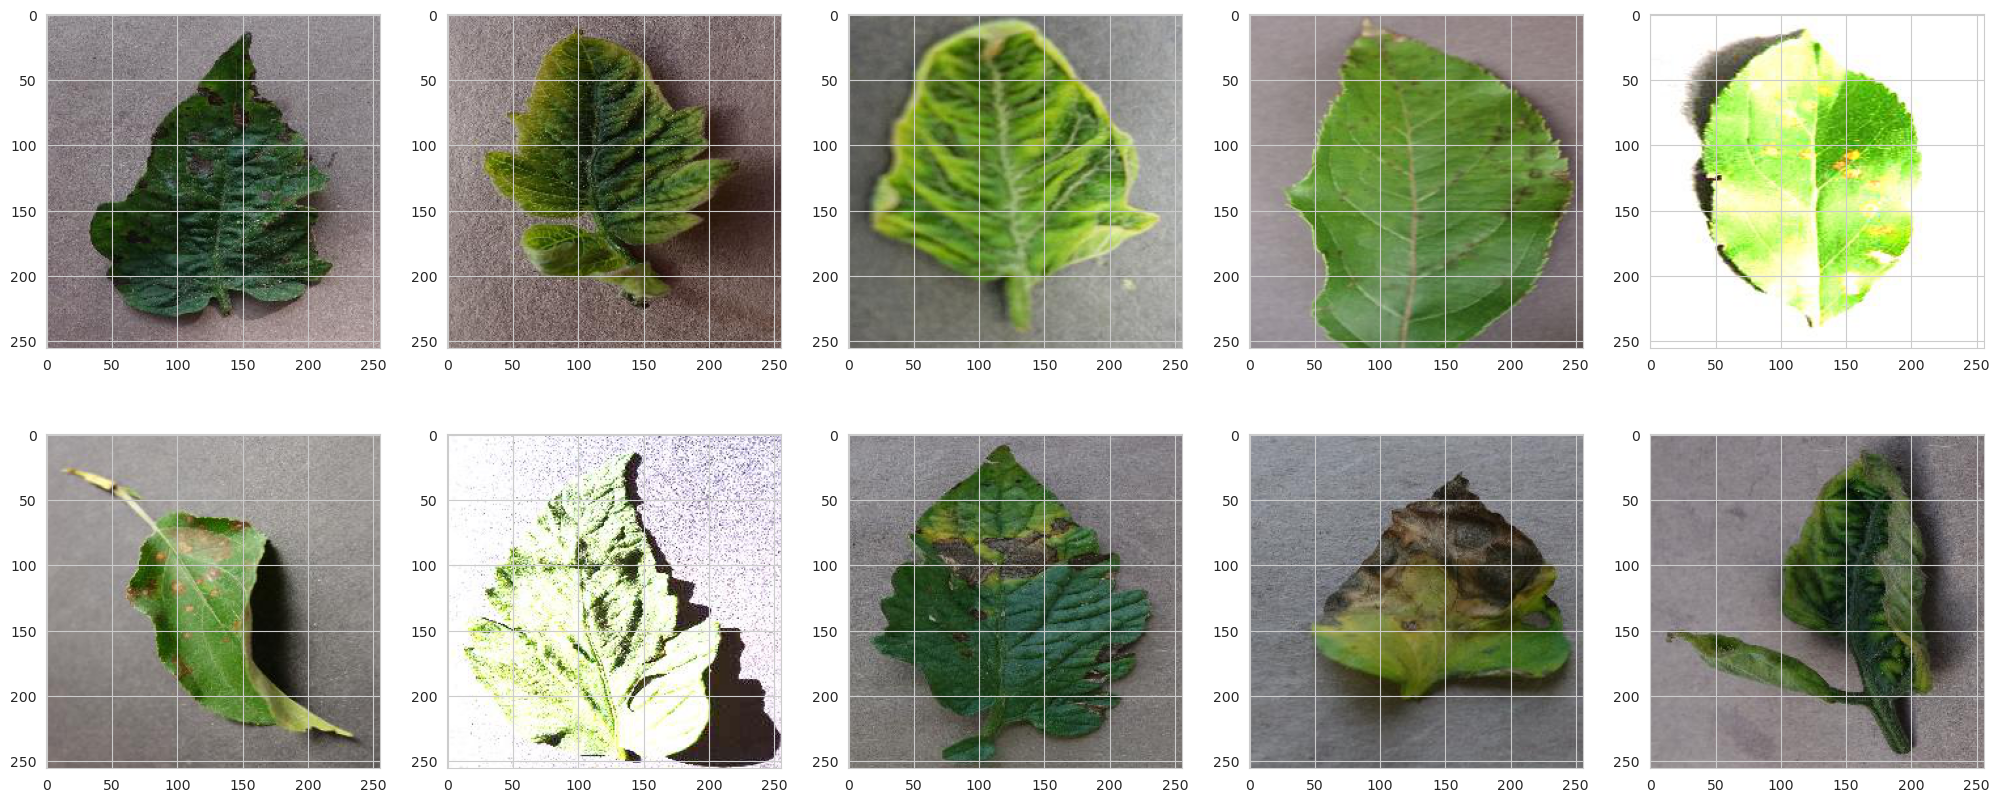

In [38]:
# Checking sample of test images
test_img_filepaths = df_test.sample(10)['filepath']
test_imgs = list([np.asarray(Image.open(fp)) for fp in test_img_filepaths])

fig, ax = plt.subplots(ncols=(len(test_imgs) // 2), nrows=2, figsize=(25, 10))
[ax[n // (len(test_imgs) // 2)][n % (len(test_imgs) // 2)].imshow(test_imgs[n]) for n in range(len(test_imgs))]

### Considerations
The goal of this classifier is to build a model robust enough to classify images of leaves without any prior preprocessing. From initial data analysis, there is a cause for concern as images in the validation and test datasets have been augmented through image preprocessing (segmentation, filtering, etc.). This is a form of data leakage, where the application of the same data augmentation techniques (in this case, image preprocessing) to the validation and test datasets can incorrectly assess model performance on unseen data, where unseen data in real-world applications comprise solely of unprocessed data.


## Citations
“14 Common Plant Diseases: How to Identify & Treat Them.” ProFlowers Blog, 15 Feb. 2017, www.proflowers.com/blog/plant-diseases.

“Insects and Their Injury to Plants.” CT.gov - Connecticut’s Official State Website, portal.ct.gov/CAES/Plant-Pest-Handbook/pph-Introductory/Insects-and-their-Injury-to-Plants.

Nazarov, Pavel A., et al. “Infectious Plant Diseases: Etiology, Current Status, Problems and Prospects in Plant Protection.” Acta Naturae, vol. 12, no. 3, 27 Oct. 2020, pp. 46–59, https://doi.org/10.32607/actanaturae.11026.

Savary, Serge, et al. “The Global Burden of Pathogens and Pests on Major Food Crops.” Nature Ecology & Evolution, vol. 3, no. 3, 4 Feb. 2019, pp. 430–439, https://doi.org/10.1038/s41559-018-0793-y.

Shoaib, Muhammad, et al. “An Advanced Deep Learning Models-Based Plant Disease Detection: A Review of Recent Research.” Frontiers in Plant Science, vol. 14, 21 Mar. 2023, www.ncbi.nlm.nih.gov/pmc/articles/PMC10070872/#:~:text=Studies%20have%20shown%20that%20CNNs, https://doi.org/10.3389/fpls.2023.1158933.

### Dataset
Bhattarai, Samir. “New Plant Diseases Dataset.” Kaggle, 2018, www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset.

Mohanty, Sharada P., et al. “Using Deep Learning for Image-Based Plant Disease Detection.” Frontiers in Plant Science, vol. 7, 22 Sept. 2016, www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2016.01419/full, https://doi.org/10.3389/fpls.2016.01419.

